In [4]:
import sys
import numpy
from scipy.fftpack import dct
import scipy.io.wavfile
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import librosa
import librosa.display
import os
from pydub import AudioSegment
import glob

In [5]:
recording_list = glob.glob("*.mp3")
print(recording_list)
count = 0
for record in recording_list:
    count += 1
    signal, sample_rate = librosa.load(record,sr=None,mono=True) #librosa automatically converts to mono, set here explicitly
    if len(record.split('-')) > 4:
        record = record.split('-')
        del record[0]
        del record[1]
        del record[-1]
        file_name = ''.join(record)
    else:
        _, _, file_name, _ = record.split('-')
    converted_name = file_name + ' ' + str(count) + '.wav'
    librosa.output.write_wav(converted_name, signal, sample_rate)

['Andropadus-importunus-Sombre Greenbul-253154.mp3']


In [6]:
deletion_list = glob.glob("*.mp3")
print(deletion_list)

for item in deletion_list:
    os.remove(item)
    

['Andropadus-importunus-Sombre Greenbul-253154.mp3']


In [7]:
records_to_process = glob.glob("*.wav")
print(records_to_process)

#for item in records_to_process:
#    sample_rate, signal = scipy.io.wavfile.read(item)
#    nyquist = sample_rate/2;
#    signal_length = len(signal)
#    total_time = signal_length/sample_rate

sample_rate, signal = scipy.io.wavfile.read('Sombre Greenbul-3.wav')
nyquist = sample_rate/2;
signal_length = len(signal)
total_time = signal_length/sample_rate

['Sombre Greenbul 1.wav']


FileNotFoundError: [Errno 2] No such file or directory: 'Sombre Greenbul-3.wav'

In [95]:
time_step = 1/sample_rate
time_axis = numpy.arange(0, signal_length/sample_rate, time_step)
print("Time Step Size: " + str(time_step))
print(len(time_axis))

Time Step Size: 2.2675736961451248e-05
2073600


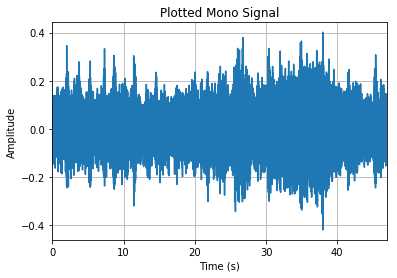

In [96]:
plt.figure(1)
plt.plot(time_axis, signal)
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.title("Plotted Mono Signal")
plt.grid(True)
plt.xlim([0, total_time])
plt.show()

In [97]:
pre_emphasis = 0.97
signal_emphasized = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

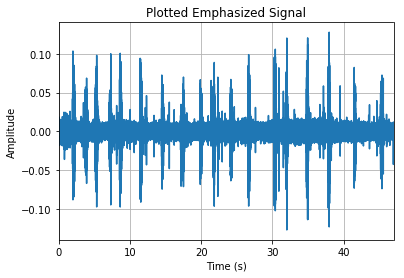

In [98]:
plt.figure(2)
plt.plot(time_axis, signal_emphasized)
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.title("Plotted Emphasized Signal")
plt.grid(True)
plt.xlim([0, total_time])
plt.show()

In [99]:
#Want 40ms frames with 50% overlap
frame_size = 0.040
overlap = 0.5

frame_length = int(frame_size * sample_rate)
signal_length_new = int(numpy.trunc((signal_length/frame_length)+1)*frame_length)
padded_bits = signal_length_new-signal_length
signal_processed = numpy.pad(signal_emphasized, (0, int(padded_bits)), 'constant')

print("Frame length: " + str(frame_length))
print("Number of padded bits at end: " + str(padded_bits))
print("Old signal length: " + str(signal_length))
print("New signal length: " + str(signal_length_new))

Frame length: 1764
Number of padded bits at end: 864
Old signal length: 2073600
New signal length: 2074464


In [100]:
factor = int(frame_length * overlap)   #Frame step?
print("Overlap frame amount: " + str(factor))
index_start = 0
index_end = frame_length
extract = signal_processed[index_start:index_end]
size = (factor,frame_length)       #Change factor here if you want to make the overlap amount dynamic
extracted = numpy.zeros(size)
for i in range(0,factor):          #Change factor here is you want to make the overlap amount dynamic
    extracted[i] = signal_processed[index_start:index_end]
    index_start = index_start + factor
    index_end = index_end + factor
    
if (extract == extracted[0]).all():
    print("Arrays contain the correct elements")

Overlap frame amount: 882
Arrays contain the correct elements


In [101]:
window_size = numpy.arange(frame_length)
window_function_explicit = 0.54 - 0.46 * numpy.cos((2 * numpy.pi * window_size) / (frame_length-1))

In [102]:
extracted = extracted * numpy.hamming(frame_length)

In [103]:
NFFT = 512
magnitude = numpy.absolute(numpy.fft.rfft(extracted, NFFT))  
power_spectrum = ((1.0 / NFFT) * ((magnitude) ** 2)) 

In [104]:
nfilt = 40

freq_low_mel = 0
freq_high_mel = (2595.0 * numpy.log10(1.0 + nyquist/700.0)) 

mel_scale = numpy.linspace(freq_low_mel, freq_high_mel, nfilt + 2)  #Need 2 additional points not counting the start and end frequencies
hz_scale = (700.0 * (10.0 ** (mel_scale / 2595.0) - 1.0)) 


bin = numpy.floor((NFFT + 1) * hz_scale / sample_rate) 

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))

for m in range(1, nfilt+1):
    f_previous = int(bin[m-1])
    f_current = int(bin[m])
    f_next = int(bin[m+1])
    
    for k in range(f_previous, f_current):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_current, f_next):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

mel_filter_scale = numpy.linspace(freq_low_mel, (sample_rate / 2), 257)

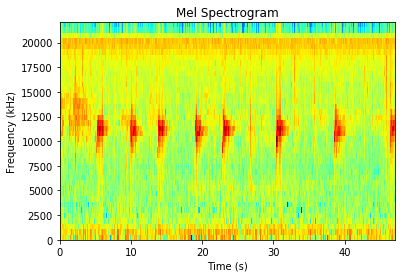

In [105]:
#INVESTIGATION TEAM GO!

# Features
filter_banks = numpy.dot(power_spectrum, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks) # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

#plt.imshow(numpy.flipud(filter_banks.T), cmap=cm.jet, aspect=0.2, extent=[0,total_time,0,4])
flipped = numpy.flipud(filter_banks.T)
plt.imshow(flipped, cmap=cm.jet, aspect='auto', extent=[0,total_time,0,nyquist])  #Not 100% about this image processing
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (s)')
plt.title('Mel Spectrogram')
plt.show()

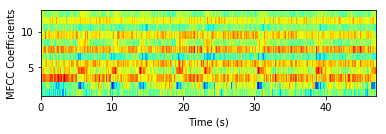

In [106]:
numceps = 13

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : numceps]
plt.imshow(numpy.flipud(mfcc.T), cmap=cm.jet, extent=[0,total_time,1,numceps])
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time (s)')
plt.show()

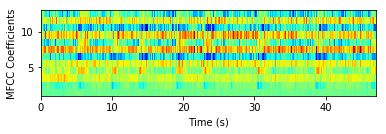

[[-221.0025085  -223.01153393 -203.34934824 ... -165.05520142
  -183.0292292  -183.26931984]
 [-114.94546032  -97.7405499   -95.08849329 ... -134.44833115
  -136.4376473  -136.25060318]
 [ -90.71004487 -104.49221137 -100.12753945 ... -110.11459161
  -141.13487546 -151.71863632]
 ...
 [ -82.03592588  -84.82810022 -107.76530591 ... -108.91495266
  -156.98836981 -164.91183367]
 [-113.19399807  -91.2970495   -94.51572429 ... -101.65342936
  -114.88314348 -116.65107174]
 [ -81.09449042  -95.4204177   -94.14283593 ... -106.57503866
  -134.23684269 -135.39470591]]


In [107]:
cep_lifter = 22

# Lifter
if cep_lifter > 0:
    (nframes, ncoeff) = numpy.shape(mfcc)
    n = numpy.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
    mfcc *= lift
    

plt.imshow(numpy.flipud(mfcc.T), cmap=cm.jet, extent=[0,total_time,1,numceps])
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time (s)')
plt.show()
print(filter_banks)

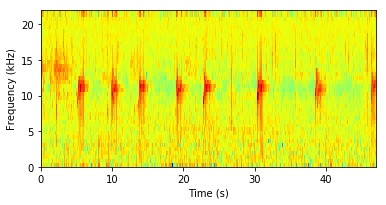

[[-1.22578122e+02 -1.31700308e+02 -1.02474328e+02 ... -5.71249308e+01
  -4.50257580e+01 -4.06457985e+01]
 [-1.65210735e+01 -6.42932446e+00  5.78652697e+00 ... -2.65180605e+01
   1.56582385e+00  6.37291816e+00]
 [ 7.71434194e+00 -1.31809859e+01  7.47480810e-01 ... -2.18432096e+00
  -3.13140431e+00 -9.09511499e+00]
 ...
 [ 1.63884609e+01  6.48312522e+00 -6.89028565e+00 ... -9.84682014e-01
  -1.89848987e+01 -2.22883123e+01]
 [-1.47696113e+01  1.41759343e-02  6.35929597e+00 ...  6.27684128e+00
   2.31203277e+01  2.59724496e+01]
 [ 1.73298964e+01 -4.10919227e+00  6.73218433e+00 ...  1.35523198e+00
   3.76662846e+00  7.22881542e+00]]


In [108]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + numpy.finfo(float).eps)
plt.imshow(numpy.flipud(filter_banks.T), cmap=cm.jet, extent=[0,total_time,0,22.05])
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (s)')
plt.show()
print(filter_banks)

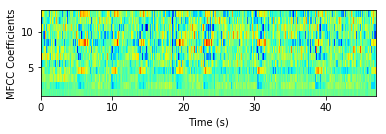

In [109]:
mfcc -= (numpy.mean(mfcc, axis=0) + numpy.finfo(float).eps)

plt.imshow(numpy.flipud(mfcc.T), cmap=cm.jet, extent=[0,total_time,1,numceps])
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time (s)')
plt.show()